In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from attention_graph_util import *
import seaborn as sns
import itertools 
import matplotlib as mpl

rc={'font.size': 10, 'axes.labelsize': 10, 'legend.fontsize': 10.0, 
    'axes.titlesize': 32, 'xtick.labelsize': 20, 'ytick.labelsize': 16}
plt.rcParams.update(**rc)
mpl.rcParams['axes.linewidth'] = .5 #set the value globally

import torch
from transformers import *
from transformers import BertConfig, BertForMaskedLM, BertTokenizer


import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

def plot_attention_heatmap(att, s_position, t_positions, sentence):

  cls_att = np.flip(att[:,s_position, t_positions], axis=0)
  xticklb = input_tokens= list(itertools.compress(['<cls>']+sentence.split(), [i in t_positions for i in np.arange(len(sentence)+1)]))
  yticklb = [str(i) if i%2 ==0 else '' for i in np.arange(att.shape[0],0, -1)]
  ax = sns.heatmap(cls_att, xticklabels=xticklb, yticklabels=yticklb, cmap="YlOrRd")
  return ax


def convert_adjmat_tomats(adjmat, n_layers, l):
   mats = np.zeros((n_layers,l,l))
   
   for i in np.arange(n_layers):
       mats[i] = adjmat[(i+1)*l:(i+2)*l,i*l:(i+1)*l]
       
   return mats



In [2]:
# Transformers has a unified API
# for 8 transformer architectures and 30 pretrained weights.
#          Model          | Tokenizer          | Pretrained weights shortcut
MODELS = [(BertModel,       BertTokenizer,       'bert-base-uncased'),
          (OpenAIGPTModel,  OpenAIGPTTokenizer,  'openai-gpt'),
          (GPT2Model,       GPT2Tokenizer,       'gpt2'),
          (CTRLModel,       CTRLTokenizer,       'ctrl'),
          (TransfoXLModel,  TransfoXLTokenizer,  'transfo-xl-wt103'),
          (XLNetModel,      XLNetTokenizer,      'xlnet-base-cased'),
          (XLMModel,        XLMTokenizer,        'xlm-mlm-enfr-1024'),
          (DistilBertModel, DistilBertTokenizer, 'distilbert-base-uncased'),
          (RobertaModel,    RobertaTokenizer,    'roberta-base')]

# Each architecture is provided with several class for fine-tuning on down-stream tasks, e.g.
BERT_MODEL_CLASSES = [BertModel, BertForPreTraining, BertForMaskedLM, BertForNextSentencePrediction,
                      BertForSequenceClassification, BertForTokenClassification, BertForQuestionAnswering]

# All the classes for an architecture can be initiated from pretrained weights for this architecture
# Note that additional weights added for fine-tuning are only initialized
# and need to be trained on the down-stream task
pretrained_weights = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained_weights)

In [3]:
model = BertForMaskedLM.from_pretrained(pretrained_weights,
                                  output_hidden_states=True,
                                  output_attentions=True)


In [4]:
tokenizer.encode([tokenizer._mask_token])

[101, 103, 102]

In [14]:
sentences = {}
src = {}
targets = {}
sentences[1] = "She asked the doctor about "+tokenizer.mask_token+" backache"
src[1] = 6
targets[1] = (1,4) 
sentences[0] = "He talked to her about his book"
src[0] = 6
targets[0] = (1,4) 
sentences[2] = "The author talked to Sara about "+tokenizer.mask_token+" book"
src[2] = 7
targets[2] = (2,5) 

sentences[3] = "John tried to convince Mary of his love and brought flowers for "+tokenizer.mask_token
src[3] = 13
targets[3] = (1,5) 

sentences[4] = "Mary convinced John of "+tokenizer.mask_token+" love"
src[4] = 5
targets[4] = (1,3) 

ex_id = 2
sentence = sentences[ex_id]
tokens = ['[cls]']+tokenizer.tokenize(sentence)+['[sep]']
print(len(tokens), tokens)
tf_input_ids = tokenizer.encode(sentence)
print(tokenizer.decode(tf_input_ids))
input_ids = torch.tensor([tf_input_ids])
all_hidden_states, all_attentions = model(input_ids)[-2:]

_attentions = [att.detach().numpy() for att in all_attentions]
attentions_mat = np.asarray(_attentions)[:,0]
print(attentions_mat.shape)

10 ['[cls]', 'the', 'author', 'talked', 'to', 'sara', 'about', '[MASK]', 'book', '[sep]']
[CLS] the author talked to sara about [MASK] book [SEP]
(24, 16, 10, 10)


In [15]:
output = model(input_ids)[0]
predicted_target = torch.nn.Softmax()(output[0,src[ex_id]])

print(np.argmax(output.detach().numpy()[0], axis=-1))
print(tokenizer.decode(np.argmax(output.detach().numpy()[0], axis=-1)))
print(tf_input_ids[src[ex_id]], tokenizer.decode([tf_input_ids[src[ex_id]]]))
print(tf_input_ids[targets[ex_id][0]], tokenizer.decode([tf_input_ids[targets[ex_id][0]]]), predicted_target[tf_input_ids[targets[ex_id][0]]])
print(tf_input_ids[targets[ex_id][1]], tokenizer.decode([tf_input_ids[targets[ex_id][1]]]), predicted_target[tf_input_ids[targets[ex_id][1]]])

his_id = tokenizer.encode(['his'])[1]
her_id = tokenizer.encode(['her'])[1]

print(his_id, her_id)
print("his prob:", predicted_target[his_id], "her prob:", predicted_target[her_id], "her?", predicted_target[her_id] > predicted_target[his_id])

[1012 1996 3166 5720 2000 7354 2055 1996 2338 1012]
. the author talked to sara about the book.
103 [MASK]
3166 author tensor(4.4339e-08, grad_fn=<SelectBackward>)
7354 sara tensor(1.5471e-08, grad_fn=<SelectBackward>)
2010 2014
his prob: tensor(0.3558, grad_fn=<SelectBackward>) her prob: tensor(0.1219, grad_fn=<SelectBackward>) her? tensor(False)


/home/dehghani/anaconda3/envs/indist/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


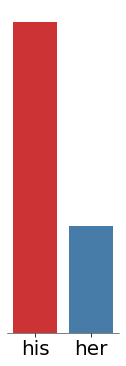

In [16]:
fig = plt.figure(1,figsize=(2,6))
ax = sns.barplot(['his', 'her'], [predicted_target[his_id].detach().numpy(), predicted_target[her_id].detach().numpy()], linewidth=0, palette='Set1')
sns.despine(fig=fig, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
ax.set_yticks([])
plt.savefig('rat_bert_bar_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')

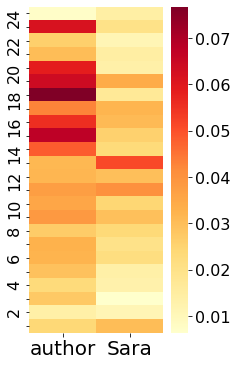

In [17]:
plt.figure(1,figsize=(3,6))
plot_attention_heatmap(attentions_mat.sum(axis=1)/attentions_mat.shape[1], src[ex_id], t_positions=targets[ex_id], sentence=sentence)
plt.savefig('rat_bert_att_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')

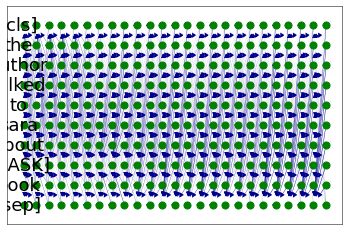

In [18]:
res_att_mat = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
res_att_mat = res_att_mat + np.eye(res_att_mat.shape[1])[None,...]
res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]
 
res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=tokens)

res_G = draw_attention_graph(res_adj_mat,res_labels_to_index, n_layers=res_att_mat.shape[0], length=res_att_mat.shape[-1])

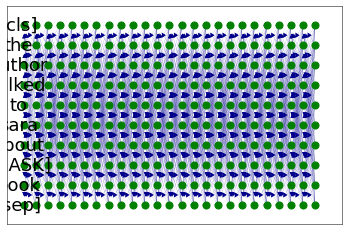

In [19]:
output_nodes = []
input_nodes = []
for key in res_labels_to_index:
    if 'L24' in key:
        output_nodes.append(key)
    if res_labels_to_index[key] < attentions_mat.shape[-1]:
        input_nodes.append(key)

flow_values = compute_flows(res_G, res_labels_to_index, input_nodes, length=attentions_mat.shape[-1])
flow_G = draw_attention_graph(flow_values,res_labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])

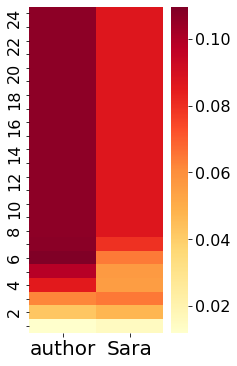

In [20]:
flow_att_mat = convert_adjmat_tomats(flow_values, n_layers=attentions_mat.shape[0], l=attentions_mat.shape[-1])

plt.figure(1,figsize=(3,6))
plot_attention_heatmap(flow_att_mat, src[ex_id], t_positions=targets[ex_id], sentence=sentence)
plt.savefig('res_fat_bert_att_{}.png'.format(ex_id), format='png', transparent=True,dpi=360, bbox_inches='tight')

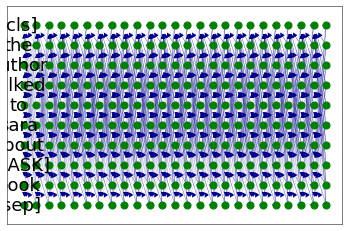

In [21]:
joint_attentions = compute_joint_attention(res_att_mat, add_residual=False)
joint_att_adjmat, joint_labels_to_index = get_adjmat(mat=joint_attentions, input_tokens=tokens)

G = draw_attention_graph(joint_att_adjmat,joint_labels_to_index, n_layers=joint_attentions.shape[0], length=joint_attentions.shape[-1])

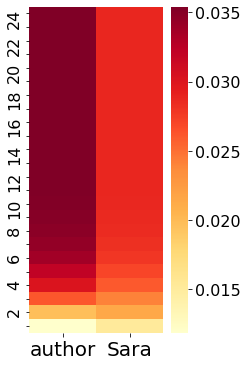

In [22]:
plt.figure(1,figsize=(3,6))
plot_attention_heatmap(joint_attentions, src[ex_id], t_positions=targets[ex_id], sentence=sentence)
plt.savefig('res_jat_bert_att_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')